In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

      phase speed     phase
Mean    -0.000002 -6.359112
Std      0.008713  2.486367
Var      0.000076  6.182020


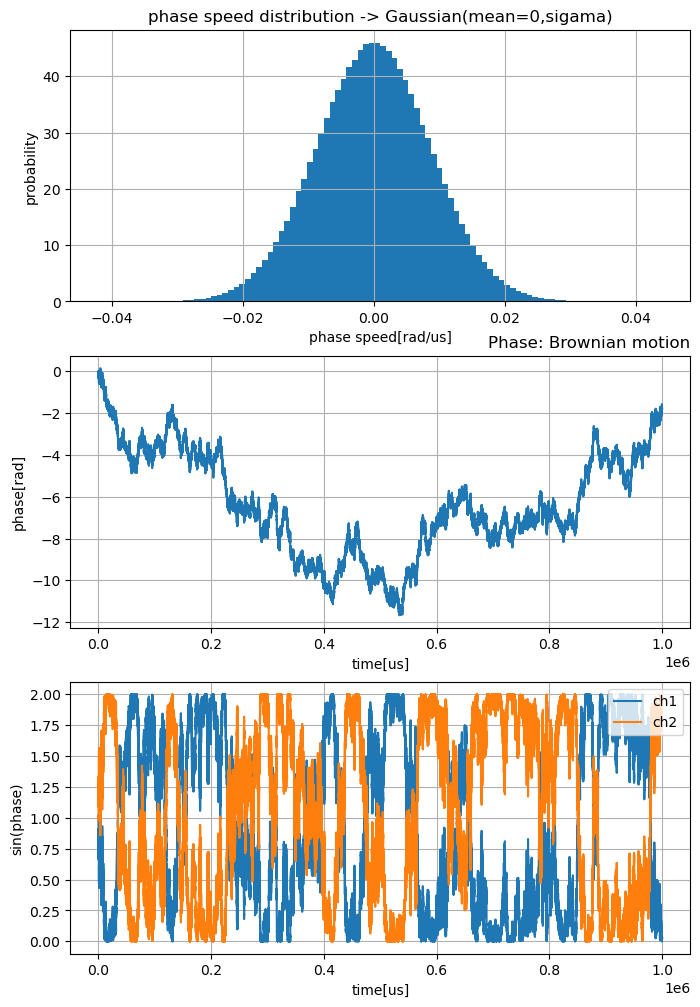

In [2]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.5/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

## 噪声种类

In [4]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())

def simu_M1_with_Measure(time_exposure,measure_method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M1=np.zeros_like(phase_speed_M1)
    phase_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量出的反馈量
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
        ###引入shot noise
        ch1_measure=measure_count(sig_ch1_exposure[i],measure_method)#rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
        ch2_measure=measure_count(sig_ch2_exposure[i],measure_method)#rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
        phase_measure_M1[i]=get_phase_from_count(ch1_measure,ch2_measure)
        #c0=fb_weight(phase_measure_M1[i],time_exposure) 
        c0=phase_measure_M1[i]
        
        
        ##---反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M1[i+1,0]-=c0 # 反馈到下一个exposure

        phase_offest=phase_M1[i,-1]
    phase_out_M1=np.cumsum(phase_speed_M1.reshape(-1))
    return phase_out_M1,phase_measure_M1

In [23]:
df_noise=pd.DataFrame(columns=['time_exposure','phase_var','measure_var'])
time_test=[2,5,10,20,40,50,80,100,200,250,400,500,800]
time_d=[]
phase_var=[]
measure_var=[]
for time_exposure in time_test:
    for method in [0,1,2]:
        phase_out_M1,phase_measure_M1=simu_M1_with_Measure(time_exposure,method)
        time_d.append(time_exposure)
        phase_var.append(np.var(phase_out_M1))
        measure_var.append(np.var(phase_measure_M1))
df_noise['time_exposure']=time_d
df_noise['phase_var']=phase_var
df_noise['measure_var']=measure_var

100%|██████████| 1250/1250 [00:00<00:00, 12795.41it/s]


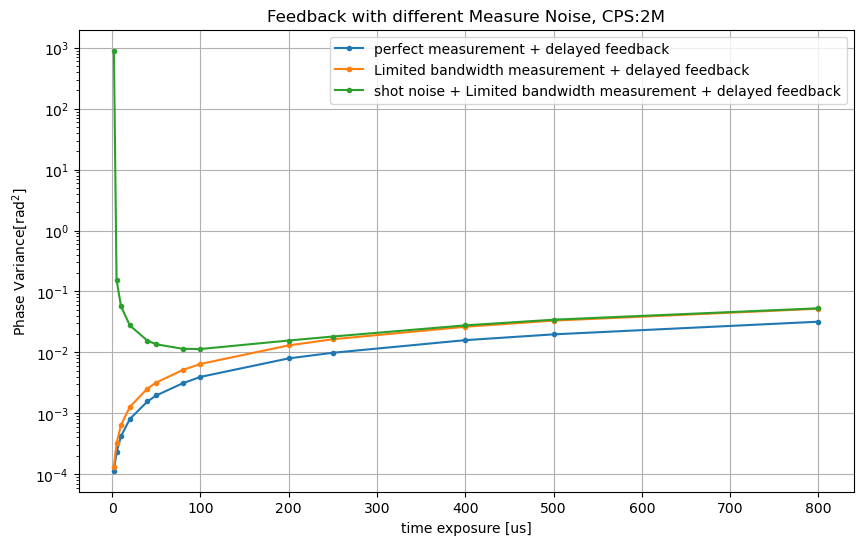

In [24]:
meas_meath=['perfect measurement + delayed feedback',
            'Limited bandwidth measurement + delayed feedback',
            'shot noise + Limited bandwidth measurement + delayed feedback']
plt.figure(figsize=(10,6))
plt.title('Feedback with different Measure Noise, CPS:{}M'.format(SIG_AMP*2))
for i in range(3):
    plt.plot(df_noise['time_exposure'][i::3],df_noise['phase_var'][i::3],'.-',label='{}'.format(meas_meath[i]))
plt.grid()
plt.legend()
plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Phase Variance[rad$^2$]')
plt.xlabel('time exposure [us]')
plt.show()

## 不同反馈方法

In [18]:
def fb_weight(measure, time_exposure, sigma=1.2):
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=sigma*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure))
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    return measure_filtered
    
def simu_phase(phase_speed,time_exposure,method):
    """
    method 1: instant feedback  
    method 4: weighted feedback  
    method 5: weighted feedback with iteration
    """
    
    time_iter1=2 # method 3 迭代参数，每隔time_iter1个exposure再进行一次测量
    
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M=np.zeros_like(phase_speed_M)
    phase_measure_M=np.zeros(phase_speed_M.shape[0]) # 测量出的反馈量
    phase_measure_it1_M5=np.zeros(phase_speed_M.shape[0])
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M[i]=np.cumsum(phase_speed_M[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M[i],2)
        ###引入shot noise
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
        phase_measure_M[i]=get_phase_from_count(ch1_measure,ch2_measure)
        
        
        if i<(sig_ch1_exposure.shape[0]-1):
            if method==1:
                phase_speed_M[i+1,0]-=phase_measure_M[i] # 反馈到下一个exposure的起始点
            if method==4:
                c0=fb_weight(phase_measure_M[i],time_exposure,sigma=1.2)
                phase_speed_M[i+1,0]-=c0 # 均匀反馈到下一个exposure时间
        
        if method==5:
            ##-- 反馈
            if i<(sig_ch1_exposure.shape[0]-1):
                c0=fb_weight(phase_measure_M[i],time_exposure,sigma=0.8)
                phase_speed_M[i+1,0]-=c0#/time_exposure # 反馈到下一个exposure
            
            ##-- 迭代反馈 one 10*time_exposure
            
            if i%time_iter1==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-1):
                phaseit1=phase_M[i,-1]+phase_speed_M[i+1,0]
                suffix1=get_sig_from_phase(phaseit1,1)
                suffix2=get_sig_from_phase(phaseit1,2)
                ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
                ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
                phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
                phase_measure_it1_M5[i]=phase_measure_M5_it1
                c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*time_iter1,sigma=0.7)
                phase_speed_M[i+1,1]-=c0

        phase_offest=phase_M[i,-1]
    phase_out_M=np.cumsum(phase_speed_M.reshape(-1))
    return phase_out_M


In [19]:
df=pd.DataFrame(columns=['time_exposure','phase_var_M1','phase_var_M4','phase_var_M5'])
time_test=[2,5,10,20,40,50,100,200,400,500,800]
time_d=[]
phase_M1=[]
phase_M4=[]
phase_M5=[]
phase_var_M1=[]
phase_var_M4=[]
phase_var_M5=[]
for time_exposure in time_test:
    time_d.append(time_exposure)
    phase_out=simu_phase(phase_speed,time_exposure=time_exposure,method=1)
    phase_M1.append(phase_out)
    phase_var_M1.append(np.var(phase_out))
    phase_out=simu_phase(phase_speed,time_exposure=time_exposure,method=4)
    phase_M4.append(phase_out)
    phase_var_M4.append(np.var(phase_out))
    phase_out=simu_phase(phase_speed,time_exposure=time_exposure,method=5)
    phase_M5.append(phase_out)
    phase_var_M5.append(np.var(phase_out))
df['time_exposure']=time_d
df['phase_M1']=phase_M1
df['phase_M4']=phase_M4
df['phase_M5']=phase_M5
df['phase_var_M1']=phase_var_M1
df['phase_var_M4']=phase_var_M4
df['phase_var_M5']=phase_var_M5

df

100%|██████████| 1250/1250 [00:00<00:00, 3988.65it/s]


,time_exposure,phase_var_M1,phase_var_M4,phase_var_M5,phase_M1,phase_M4,phase_M5
0,2,434.578144,0.007145,0.004677,"[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409..."
1,5,0.154726,0.007870,0.005577,"[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409..."
2,10,0.057768,0.008618,0.006400,"[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409..."
3,20,0.027352,0.009123,0.007433,"[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409..."
4,40,0.015107,0.009608,0.008652,"[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409..."
5,50,0.013161,0.009567,0.009363,"[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409..."
6,100,0.011332,0.011384,0.012438,"[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409..."
7,200,0.015539,0.016694,0.018627,"[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409..."
8,400,0.027339,0.029145,0.034406,"[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409..."
9,500,0.034047,0.036014,0.042965,"[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409...","[0.0, 0.007169970899109232, 0.0100535783741409..."


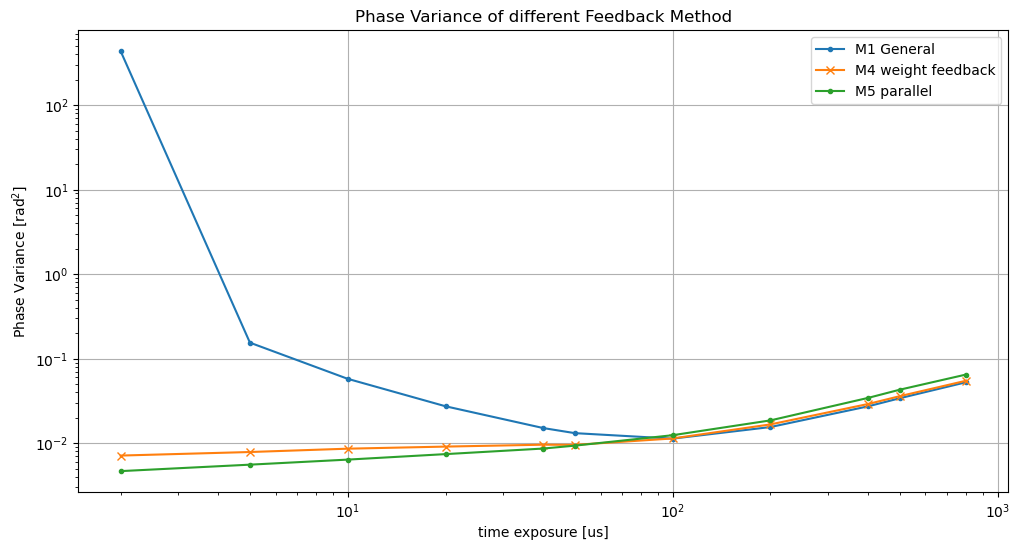

In [31]:
plt.figure(figsize=(12,6))
plt.plot(df['time_exposure'],df['phase_var_M1'],'.-',label='M1 General')
plt.plot(df['time_exposure'],df['phase_var_M4'],'x-',label='M4 weight feedback')
plt.plot(df['time_exposure'],df['phase_var_M5'],'.-',label='M5 parallel')
plt.legend() 
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Phase Variance [rad$^2$]')
plt.xlabel('time exposure [us]')
plt.title('Phase Variance of different Feedback Method')
plt.show()

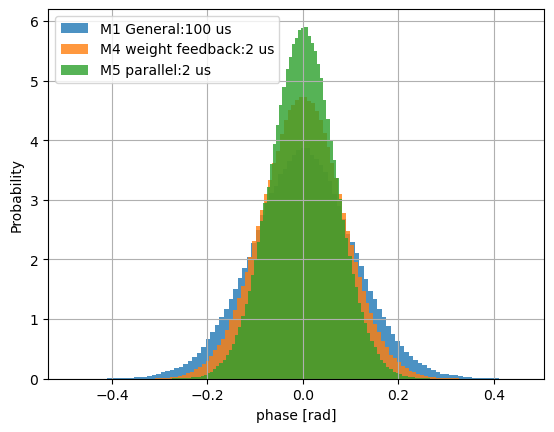

In [67]:
m1_phase_good=df[df.time_exposure==100].phase_M1.values[0]
m4_phase_good=df[df.time_exposure==2].phase_M4.values[0]
m5_phase_good=df[df.time_exposure==2].phase_M5.values[0]
plt.hist(m1_phase_good,bins=100,alpha=0.8,density=True,label='M1 General:100 us')
plt.hist(m4_phase_good,bins=100,alpha=0.8,density=True,label='M4 weight feedback:2 us')
plt.hist(m5_phase_good,bins=100,alpha=0.8,density=True,label='M5 parallel:2 us')
plt.legend()
plt.xlabel('phase [rad]')
plt.ylabel('Probability')
plt.grid()
plt.show()

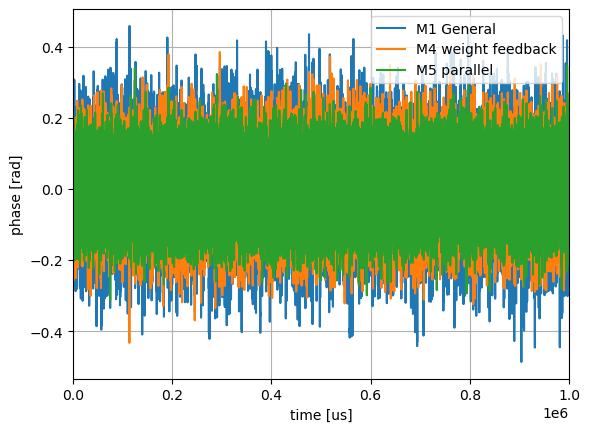

In [62]:
plt.plot(time_axis,m1_phase_good,label='M1 General')
plt.plot(time_axis,m4_phase_good,label='M4 weight feedback')
plt.plot(time_axis,m5_phase_good,label='M5 parallel')
plt.xlim(0,1e6)
plt.grid()
plt.legend(loc=1)
plt.xlabel('time [us]')
plt.ylabel('phase [rad]')
plt.show()

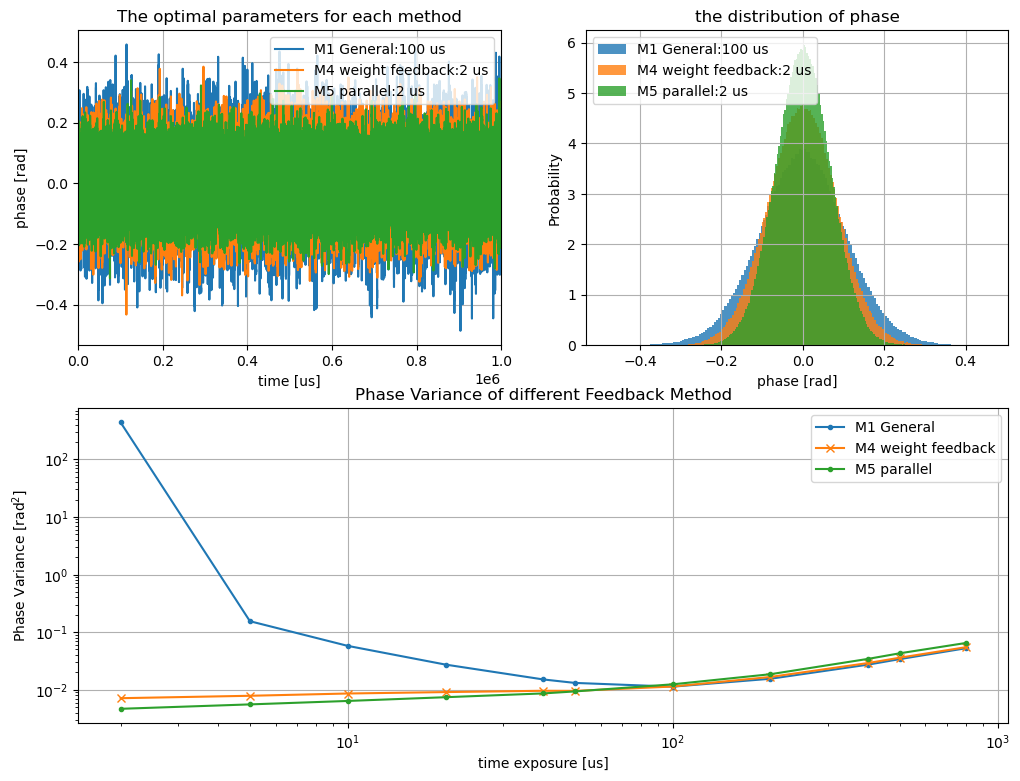

In [86]:
plt.figure(figsize=(12,9))
plt.subplot(2,1,2)

plt.title('Phase Variance of different Feedback Method')
plt.plot(df['time_exposure'],df['phase_var_M1'],'.-',label='M1 General')
plt.plot(df['time_exposure'],df['phase_var_M4'],'x-',label='M4 weight feedback')
plt.plot(df['time_exposure'],df['phase_var_M5'],'.-',label='M5 parallel')
plt.legend() 
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Phase Variance [rad$^2$]')
plt.xlabel('time exposure [us]')

plt.subplot(2,2,1)
plt.title('The optimal parameters for each method')
plt.plot(time_axis,m1_phase_good,label='M1 General:100 us')
plt.plot(time_axis,m4_phase_good,label='M4 weight feedback:2 us')
plt.plot(time_axis,m5_phase_good,label='M5 parallel:2 us')
plt.xlim(0,1e6)
plt.grid()
plt.legend(loc=1)
plt.xlabel('time [us]')
plt.ylabel('phase [rad]')

plt.subplot(2,2,2)
plt.title('the distribution of phase')
plt.hist(m1_phase_good,bins=180,alpha=0.8,density=True,label='M1 General:100 us')
plt.hist(m4_phase_good,bins=180,alpha=0.8,density=True,label='M4 weight feedback:2 us')
plt.hist(m5_phase_good,bins=180,alpha=0.8,density=True,label='M5 parallel:2 us')
plt.legend()
plt.xlabel('phase [rad]')
plt.ylabel('Probability')
plt.grid()
plt.show()